# Start

In [1]:
import sys
import json
#if argv['params']['general'].get('scenario_path_S3') contains immense s3 path (ex: uuid-123-456-789/)
params = {'general':{'periods':['am','pm','ip','op']}}
default = {'scenario':'orchestrator2','training_folder': '../..', 'params': params} # Default execution parameters
# here sceneario: demand is only use not on lambda.
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)

{'scenario': 'orchestrator2', 'training_folder': '../..', 'params': {'general': {'periods': ['am', 'pm', 'ip', 'op']}}}


In [2]:

import pandas as pd
import geopandas as gpd
import numpy as np
import os
import simplejson
import seaborn as sns
import io
import PIL
import matplotlib.pyplot as plt


In [3]:
periods = argv['params']['general']['periods']
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
print('On Lambda : ', on_lambda)
training_folder = argv['training_folder']
input_folder = training_folder +r'/inputs/'
if on_lambda:
    bucket_name = 'quetzal-immense' #os.environ.get('BUCKET_NAME')
    output_folder = training_folder + '/outputs/'
    scenario_folder = training_folder + '/inputs/'
    scenario_folders = []
    input_folders = []
    for p in periods:
        folder = 's3://' + bucket_name + '/' + p + '/'
        scenario_folders.append(folder)
        input_folders.append(input_folder + p + '/')

else:
    output_folder = training_folder + '/scenarios/' + argv['scenario'] + '/outputs/'
    scenario_folder = training_folder + '/scenarios/' + argv['scenario'] + '/inputs/'
    scenario_folders = []
    input_folders = []
    for p in periods:
        folder = training_folder + '/scenarios/' + p + '/'
        scenario_folders.append(folder)
        input_folders.append(input_folder + p + '/')
    
print('input folder: ', input_folders)
print('output folder: ', output_folder)
print('scen folder : ', scenario_folders)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

On Lambda :  False
input folder:  ['../../inputs/am/', '../../inputs/pm/', '../../inputs/ip/', '../../inputs/op/']
output folder:  ../../scenarios/orchestrator2/outputs/
scen folder :  ['../../scenarios/am/', '../../scenarios/pm/', '../../scenarios/ip/', '../../scenarios/op/']


# import matrix and modifiy to the right form

In [4]:
def add_index(df,name_column,list_values):
    final = pd.DataFrame()
    for a in list_values:
        df_copy = df.copy()
        df_copy[name_column] = a
        final = pd.concat([df_copy,final])
    return(final)
def change_matrix_time(df):
    df = df[df["origin"] != df["destination"] ]
    df.loc[df["vehicle_class"].isin(['C_other', 'C_EB']),"mode"] = "voiture"
    df.loc[df["mode"] == "voiture","sub_mode"] = "vp"
    df.loc[df["vehicle_class"].isin(['BPAX', 'RPAX']),"mode"] = "tc"
    df.loc[df["vehicle_class"] == "BPAX","sub_mode"] = "autocar"
    df.loc[df["vehicle_class"] == "RPAX","sub_mode"] = "rail"

    #df = df.groupby(["origin","destination","time_period","mode","sub_mode"])[["time"]].mean().reset_index()

    tc_seg = add_index(df.loc[df["mode"] == "tc"],"segment",[11,12,13,14,15])
    
    all_seg = add_index(df,"segment",[i for i in range(11)])
    df = pd.concat([tc_seg,all_seg ])
#only C_EB can be seg 7 in car 
    df = df.loc[~((df["vehicle_class"] == "C_EB") & (df["segment"] != 7))]
    df = df.loc[~((df["vehicle_class"] == "C_other") & (df["segment"] == 7))]
    df["period"] = df["time_period"]
    return(df.set_index(["origin","destination","period","mode","sub_mode","segment"])["time"])
def change_matrix_volume(csv):
    
    df = pd.read_csv(input_folder + csv)
    df = df[df["origin"] != df["destination"] ]
    df = df.groupby(["origin","destination","time_period","vehicle_class"])[["volume"]].sum().reset_index()
    df["origin"] = "zone_" + df["origin"].astype(str)
    df["destination"] = "zone_" + df["destination"].astype(str)
    od_set = set(zip(df['origin'],df['destination'],df['time_period'],df['vehicle_class']))
    df.loc[df["vehicle_class"].isin(['C_other', 'C_EB']),"mode"] = "voiture"
    df.loc[df["mode"] == "voiture","sub_mode"] = "vp"
    df.loc[df["vehicle_class"].isin(['BPAX', 'RPAX']),"mode"] = "tc"
    df.loc[df["vehicle_class"] == "BPAX","sub_mode"] = "autocar"
    df.loc[df["vehicle_class"] == "RPAX","sub_mode"] = "rail"
    df = df.groupby(["origin","destination","time_period","mode","sub_mode"])[["volume"]].sum().reset_index()

    tc_seg = add_index(df.loc[df["mode"] == "tc"],"segment",[11,12,13,14,15])
    
    all_seg = add_index(df,"segment",[i for i in range(11)])
    df = pd.concat([tc_seg,all_seg ])
    
#only C_EB can be seg 7 in car 
    #df = df.loc[~((df["vehicle_class"] == "C_EB") & (df["segment"] != 7))]
    #
    #df = df.loc[~((df["vehicle_class"] == "C_other") & (df["segment"] == 7))]
    df["period"] = df["time_period"]
    
    return df.set_index(["origin","destination","period","mode","sub_mode","segment"])["volume"], od_set

In [5]:
vol_ref, od_set = change_matrix_volume('base/volumes/volumes.csv')
vol_ref = (vol_ref /vol_ref .reset_index().groupby(["period","mode","sub_mode","origin","destination"])["segment"].count())

In [6]:
# concat PT skims
period_dict={'am':'AM','pm':'PM','ip':'IP','op':'OP'}
cols = ['origin', 'destination', 'time_period', 'vehicle_class', 'time']
skim = pd.DataFrame()
ref_skim = pd.DataFrame()
for period, ref_folder, scen_folder in zip(periods,input_folders,scenario_folders):
    print(period)
    ref_pt_skim = pd.read_csv(scen_folder+'outputs/ref_pt_skim.csv')
    pt_skim = pd.read_csv(scen_folder+'outputs/pt_skim.csv')
    
    ref_pt_skim['time_period'] = period_dict[period]
    pt_skim['time_period'] = period_dict[period]

    ref_skim = pd.concat([ref_skim, ref_pt_skim[cols]])
    skim = pd.concat([skim, pt_skim[cols]])

am
pm
ip
op


In [7]:
# get car skims
ref_car_skim = pd.read_csv(input_folder+ 'base/road_skims.csv')
car_skim = pd.read_csv(scenario_folder+'road_skims.csv')


ref_car_skim['origin'] = 'zone_' + ref_car_skim['origin'].astype(str)
ref_car_skim['destination'] = 'zone_' + ref_car_skim['destination'].astype(str)

car_skim['origin'] = 'zone_' + car_skim['origin'].astype(str)
car_skim['destination'] = 'zone_' + car_skim['destination'].astype(str)

In [8]:
# format skims
cols = ['origin', 'destination', 'time_period', 'vehicle_class', 'time','distance']
ref_skim = pd.concat([ref_skim, ref_car_skim[cols]])
skim = pd.concat([skim, car_skim[cols]])

skim = skim.set_index(['origin','destination','time_period','vehicle_class']).loc[od_set].reset_index()
ref_skim = ref_skim.set_index(['origin','destination','time_period','vehicle_class']).loc[od_set].reset_index()


/tmp/ipykernel_181685/2665160603.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  skim = skim.set_index(['origin','destination','time_period','vehicle_class']).loc[od_set].reset_index()
/tmp/ipykernel_181685/2665160603.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ref_skim = ref_skim.set_index(['origin','destination','time_period','vehicle_class']).loc[od_set].reset_index()


In [9]:
time_ref = change_matrix_time(ref_skim)/60
time_proj  = change_matrix_time(skim)/60

## essai elasticite test

time_proj = time_ref.copy()
time_proj[time_proj.index.get_level_values("mode") == "voiture"] = time_proj[time_proj.index.get_level_values("mode") == "voiture"] + time_proj[time_proj.index.get_level_values("mode") == "voiture"]*0.2

time_proj = pd.read_csv(input_folder +'time_proj.csv') .groupby(["origin","destination","sub_mode","mode","segment","period"])["time"].min()
time_ref = pd.read_csv(input_folder +'time_ref.csv').groupby(["origin","destination","sub_mode","mode","segment","period"])["time"].min()
vol_ref = pd.read_csv(input_folder +'vol_ref.csv').set_index(["origin","destination","sub_mode","mode","segment","period"])["volume"]
vol_ref = vol_ref.loc[vol_ref > 0]

## différence utility

#### we are going to do the difference of utility starting by the micro level

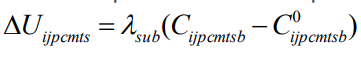

In [10]:
# Utility sub
from IPython.display import Image
Image(filename='../../inputs/base/images/utility_sub.PNG') 

In [11]:
vol_ref.name = "volumes"
time_ref.name = "time_ref"

In [12]:
import math
# mettre sous forme csv 
dico_sub = {"rail" : -0.05, "autocar" : - 0.05, "vp" : -0.1}#, "p+r" : -0.1}
sub = pd.Series(dico_sub)
sub.index.name = "sub_mode"
delta_utility_ijpcmts = (time_proj - time_ref)
delta_utility_ijpcmts_factor = delta_utility_ijpcmts * sub
delta_utility_ijpcmts_factor_e = np.exp(delta_utility_ijpcmts_factor)
#on ajoute des temps nuls pour les zones avec vol mais pas de temps
delta_utility_ijpcmts_factor_e = delta_utility_ijpcmts_factor_e.reindex(vol_ref.index).fillna(1) 


# utility Destination Choice (sum over submodes)

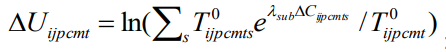

In [13]:
Image(filename=input_folder +'base/images/utility_dest.PNG') 

In [14]:
Tijpcmts_mult_0 = (vol_ref*delta_utility_ijpcmts_factor_e)
# on fait >0 pour retirer les OD 
Tijpcmts_mult_0  = Tijpcmts_mult_0.loc[Tijpcmts_mult_0 > 0]
s_Tijpcmts_mult_0 = Tijpcmts_mult_0.groupby(level = ["origin","destination","segment","mode","period"]).sum()
Tijpcmt_0  = vol_ref.groupby(level = ["origin","destination","segment","mode","period"]).sum()
delta_utility_ijpcmt = np.log(s_Tijpcmts_mult_0.div(Tijpcmt_0))

In [15]:
def proportional_share(dataframe, level):
    u = dataframe.unstack(level)
    return u.div(u.sum(axis=1), axis=0)

def multiply(series, dataframe):
    multiplier = series.reorder_levels(dataframe.index.names).reindex(dataframe.index)
    return dataframe.apply(lambda c: c*multiplier)

def multiply_series(left, right):
    return (left.sort_index() * right.sort_index()).reorder_levels(left.index.names)

In [16]:
segment = pd.read_csv(input_folder + "base/segment.csv",sep =';')
param_destination = pd.read_csv(input_folder + "base/parametre_destination.csv",sep =';').merge(segment, on = "purpose").set_index(["mode","segment"])["parameter"]
dico_mode = {"voiture" : 0.1, "tc" : 0.05}
sub = pd.Series(dico_mode )
sub.index.name = "mode"
theta_destination = param_destination/sub

In [17]:
delta_utility_ijpcmt_factor = multiply_series(delta_utility_ijpcmt, theta_destination)
delta_utility_ijpcmt_factor_e = np.exp(delta_utility_ijpcmt_factor)
delta_utility_ijpcmt_factor_e = delta_utility_ijpcmt_factor_e.loc[~delta_utility_ijpcmt_factor_e.isna()]

#  utility Time period Choice ( sum over destination)

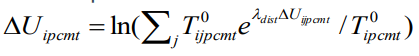

In [18]:
# utility single constraint# tout sauf segment 7
Image(filename=input_folder +'base/images/utility_single_constrain.PNG') 

In [19]:
Tijpcmt_mult_0 = multiply_series(Tijpcmt_0, delta_utility_ijpcmt_factor_e)# matrix dest is

In [20]:
s_Tijpcmt_mult_0 = Tijpcmt_mult_0.groupby(level = ["origin","segment","mode","period"]).sum()

In [21]:
Tipcmt_0  = vol_ref.groupby(level = ["origin","segment","mode","period"]).sum()
delta_utility_ipcmt = np.log(s_Tijpcmt_mult_0/Tipcmt_0)

In [22]:
param_period_mode = pd.read_csv(input_folder + "base/parametre_period_mode.csv",sep =';').merge(segment, on = "purpose").set_index(["segment"])["parameter"]
delta_utility_ipcmt_factor = delta_utility_ipcmt * param_period_mode
delta_utility_ipcmt_factor_e = np.exp(delta_utility_ipcmt_factor)
delta_utility_ipcmt_factor_e = delta_utility_ipcmt_factor_e.loc[~delta_utility_ipcmt_factor_e.isna()]

# utility Main Mode Choice (sum over periods)

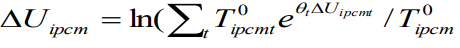

In [23]:
# utility period
Image(filename=input_folder +'base/images/utility_period.PNG') 

In [24]:
Tipcmt_mult_0 = (Tipcmt_0  * delta_utility_ipcmt_factor_e )# matrix dest is
s_Tipcmt_mult_0 = Tipcmt_mult_0.groupby(level = ["origin","segment","mode"]).sum()
Tipcm_0  = vol_ref.groupby(level = ["origin","segment","mode"]).sum()
delta_utility_ipcm = np.log(s_Tipcmt_mult_0/Tipcm_0)

In [25]:
delta_utility_ipcm_factor = delta_utility_ipcm * param_period_mode
delta_utility_ipcm_factor_e = np.exp(delta_utility_ipcm_factor)
delta_utility_ipcm_factor_e = delta_utility_ipcm_factor_e.loc[~delta_utility_ipcm_factor_e.isna()]

# frequency Modelling (sum over mode)

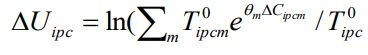

In [26]:
#utility frequency
Image(filename=input_folder +'base/images/utility_frequency.PNG') 

In [27]:
# enfait c'est pas le deltat utility ipcm mais delta C 
#TODO verifier delta C est en fait deltat utility ipcm car sinon c'est pas sans unité
Tipcm_mult_0 = (Tipcm_0  * delta_utility_ipcm_factor_e )# matrix dest is
s_Tipcm_mult_0 = Tipcm_mult_0.groupby(level = ["origin","segment"]).sum()
Tipc_0 = vol_ref.groupby(level = ["origin","segment"]).sum()
delta_utility_ipc = np.log(s_Tipcm_mult_0/Tipc_0)

In [28]:
# theta  = 0.05 selon atkins
delta_utility_ipc_factor = delta_utility_ipc * 0.05
delta_utility_ipc_factor_e = np.exp(delta_utility_ipc_factor)

# Remontée pour volume


In [29]:
#p is for projet
Tipc = Tipc_0 * delta_utility_ipc_factor_e

In [30]:
Tipcm = (Tipc * Tipcm_mult_0 / s_Tipcm_mult_0)
assert(Tipcm.sum().round(0) == Tipc.sum().round(0)),"not the same volume"


In [31]:
Tipcmt = (Tipcm * Tipcmt_mult_0 / s_Tipcmt_mult_0)
assert(Tipcmt.sum().round(0) == Tipc.sum().round(0)),"not the same volume"

In [32]:
Tijpcmt = multiply_series(Tijpcmt_mult_0, Tipcmt.div(s_Tijpcmt_mult_0))
assert(Tijpcmt.sum().round(0) == Tipc.sum().round(0)),"not the same volume"

In [33]:
Tijpcmts = multiply(series=Tijpcmt, dataframe=proportional_share(Tijpcmts_mult_0, 'sub_mode')).stack()
assert(Tijpcmts.sum().round(0) == Tipc.sum().round(0)),"not the same volume"

In [34]:
Tijpcmts_single = Tijpcmts.loc[Tijpcmts.index.get_level_values("segment") != 7]

In [35]:
Tijpcmts.sum()/vol_ref.sum()

0.9998507659937704

In [36]:
Tijpcmts.groupby("mode").sum()/vol_ref.groupby("mode").sum()

mode
tc         1.017843
voiture    0.999128
dtype: float64

# export 

In [37]:
dico_sub_mode = {"C_other":"vp",'BPAX':"autocar","RPAX":"rail","C_EB":"vp"}
vol_final = Tijpcmts.groupby(level =["origin","destination","period","sub_mode"]).sum()
#convertir
vol_base = pd.read_csv(input_folder + "base/volumes/volumes.csv")
vol_base["origin"] = "zone_" + vol_base["origin"].astype(str)
vol_base["destination"] = "zone_" + vol_base["destination"].astype(str)
vol_base["period"] = vol_base["time_period"]
vol_base["sub_mode"] = vol_base["vehicle_class"].apply(lambda x: dico_sub_mode[x] )
fratar = (vol_final / vol_base.groupby(["origin","destination","period","sub_mode"])["volume"].sum()).fillna(1)
vol_sortie= vol_base.set_index(['origin','destination','period','sub_mode',"vehicle_class","purpose" ])
vol_sortie["volume"] = vol_sortie["volume"] * fratar
vol_sortie = vol_sortie.reset_index()[["origin","destination","time_period", "vehicle_class","purpose","volume"]]
vol_sortie["origin"] = vol_sortie["origin"].apply(lambda x: x.split("_",1)[1])
vol_sortie["destination"] = vol_sortie["destination"].apply(lambda x: x.split("_",1)[1])

In [38]:
vol_sortie.to_csv(output_folder+'volumes'+'.csv')

# Segment doublement contraint

# regarder fonction de distribution de quetzal pour calc_double_constrain
# utility double constraint constraint segment 7
# boucle de rétro action ( à voir dans un second temps), autre chemin que ne concerne que le segment 7 
Image(filename=input_folder +'utility_double_constrain.png')

Tijpcmt_0 = Tijpcmt_0.loc[Tijpcmt_0.index.get_level_values("segment") == 7]
Tijpcmt = Tijpcmt.loc[Tijpcmt.index.get_level_values("segment") == 7]
Tipcmt = Tipcmt.loc[Tipcmt.index.get_level_values("segment") == 7]
vol_seg = vol_ref.loc[vol_ref.index.get_level_values("segment") == 7]
delta_utility_ijpcmt_factor_e = delta_utility_ijpcmt_factor_e .loc[delta_utility_ijpcmt_factor_e.index.get_level_values("segment") == 7]


Tjpc_0 = Tijpcmt_0.groupby(level = ["destination","segment"]).sum()
param_period_mode_7 = param_period_mode.loc[param_period_mode.index.get_level_values("segment") == 7]

def get_A_and_B(Tijpcmt,Ax_it,Bx_it,Tipcmt,Tjpc_0 = Tjpc_0):
    M = Tijpcmt.copy()
    Ax = Ax_it.copy()
    Bx = Bx_it.copy() 
    A, B = Ax.copy(), Bx.copy() # A = B = 1
    sum_Tipcmt = M.groupby(level=["origin", 'segment', 'mode', 'period']).sum()
    A = Tipcmt.div(sum_Tipcmt)   
    Ax = Ax * A
    M = A*M 
    sum_Tjpc = M.groupby(level=["destination", 'segment']).sum()
    B = Tjpc_0.div(sum_Tjpc)
    Bx = Bx * B
    M = B*M
        
    while (np.round(abs(A-1).max(), 4)> 0.0001 ) | (np.round(abs(B-1).max(), 4)> 0.0001):
        # A check
        sum_Tipcmt = M.groupby(level=["origin", 'segment', 'mode', 'period']).sum()
        A = Tipcmt.div(sum_Tipcmt) 

        # Update de la matrice et on garde la trace
        Ax = Ax * A
        M = A*M

        # B check
        sum_Tjpc = M.groupby(level=["destination", 'segment']).sum()
        B = Tjpc_0.div(sum_Tjpc)

        # Update de la matrice et on garde la trace
        Bx = Bx * B
        M = B*M
    print(
          'Ax', np.round(abs(Ax-1).mean(), 8),
    
         'Bx', np.round(abs(Bx-1).mean(), 8),
    )
    return(Ax,Bx)

iteration = 5
Ax_it = Tijpcmt.groupby(level=["origin", 'segment', 'mode', 'period']).sum() * 0 + 1
Bx_it = Tijpcmt.groupby(level=["destination", 'segment']).sum() * 0 + 1
for i in range(iteration):
# IDebut de furness
    
    Ax,Bx = get_A_and_B(Tijpcmt,Ax_it,Bx_it,Tipcmt)
    
    Tijpcmt_mult_0 = (Bx * Tijpcmt_0  * delta_utility_ijpcmt_factor_e )
    Ax = Ax.copy()
    Bx = Bx.copy()
    s_Tijpcmt_mult_0 = Tijpcmt_mult_0.groupby(level = ["origin","mode","period","segment"]).sum()
    Tipcmt_0  = vol_seg.groupby(level = ["origin","mode","period","segment"]).sum()
    delta_utility_ipcmt = np.log(s_Tijpcmt_mult_0 / Tipcmt_0)

    delta_utility_ipcmt_factor = delta_utility_ipcmt * param_period_mode_7 
    delta_utility_ipcmt_factor_e = np.exp(delta_utility_ipcmt_factor)
    
    # period choice utility
    Tipcmt_mult_0 = (Tipcmt_0  * delta_utility_ipcmt_factor_e )
    s_Tipcmt_mult_0 = Tipcmt_mult_0.groupby(level = ["origin","mode","segment"]).sum()

    Tipcm_0  = vol_seg.groupby(level = ["origin","mode","segment"]).sum()
    delta_utility_ipcm = np.log(s_Tipcmt_mult_0 / Tipcm_0)
    delta_utility_ipcm_factor = delta_utility_ipcm * param_period_mode_7 
    delta_utility_ipcm_factor_e = np.exp(delta_utility_ipcm_factor)
     
    #  mode choice utility
    Tipcm_mult_0 = (Tipcm_0  * delta_utility_ipcm_factor_e )# matrix dest is
    s_Tipcm_mult_0 = Tipcm_mult_0.groupby(level = ["origin","segment"]).sum()
    
    
    Tipc_0 = vol_seg.groupby(level = ["origin","segment"]).sum()
    delta_utility_ipc = np.log(s_Tipcm_mult_0 / Tipc_0)
    delta_utility_ipc_factor = delta_utility_ipc * 0.05
    delta_utility_ipc_factor_e = np.exp(delta_utility_ipc_factor)
    # calcul des volumes
    Tipc = Tipc_0 * delta_utility_ipc_factor_e
    Tipcm = (Tipc * Tipcm_mult_0 / s_Tipcm_mult_0)
    Tipcmt = (Tipcm * Tipcmt_mult_0 / s_Tipcmt_mult_0)
    
    Tijpcmt = multiply_series( Tijpcmt_mult_0,Tipcmt.div(s_Tijpcmt_mult_0))
    print('j', (abs(Tijpcmt_0.groupby(level = ["destination","segment"]).sum() - (Tijpcmt).groupby(level = ["destination","segment"]).sum()).sum())/len(Tijpcmt))
    print('i', (abs(Tipcm - (Tijpcmt).groupby(level = ["origin", 'segment', 'mode']).sum()).sum())/len(Tipcm))
    print('max diff contrainte B, contrainte A',(abs(Tijpcmt_0.groupby(level = ["destination","segment"]).sum()- (Tijpcmt).groupby(level = ["destination","segment"]).sum()).max(),abs(Tipcm - (Tijpcmt).groupby(level = ["origin", 'segment', 'mode']).sum()).max()))
    
                                                   
    Ax_it = Ax.copy()
    Bx_it = Bx.copy()
    # mettre un furness dans la boucle 


    #print('inext', (abs(Tipcm - (B*Tijpcmt).groupby(level = ["origin", 'segment', 'mode']).sum()).sum())/len(Tipcm))


    print('————————————————————————————————————————')
    #B = B/B.mean()
    

Tijpcmts_double = multiply(series = Tijpcmt,dataframe = proportional_share(Tijpcmts_mult_0.loc[Tijpcmts_mult_0.index.get_level_values("segment") == 7],'sub_mode')).stack()

Tijpcmts = pd.concat([Tijpcmts_single,Tijpcmts_double])

Tijpcmts.sum()/ vol_ref.sum()

# Sorties

## Elasticité

In [39]:
vol_ref_log = np.log(vol_ref)
vol_proj = Tijpcmts.reorder_levels(vol_ref.index.names).reindex(vol_ref.index)
vol_proj_log = np.log(vol_proj)
time_ref = time_ref.reindex(vol_ref.index).fillna(1)
time_proj =  time_proj.reindex(vol_ref.index).fillna(1)
vol_time_ref = time_ref * vol_ref
vol_time_proj = time_proj * vol_ref
diff_time = time_proj - time_ref 
diff_vol = vol_proj - vol_ref
vol_diff_time = diff_time * vol_ref



time_ref_log = np.log(time_ref)
time_proj_log = np.log(time_proj)

In [40]:
# sortir fonction pour period, mode et genre period mode 

In [41]:
def sortie_tableau(group):
    sum_diff_vol = diff_vol.groupby(level = group).sum()
    sum_vol = vol_ref.groupby(level = group).sum()
    vol_el = (sum_vol + sum_diff_vol)/sum_vol
    avg_diff_time = vol_diff_time.groupby(level = group).sum()/vol_ref.groupby(level = group).sum()
    avg_time_ref = vol_time_ref.groupby(level = group).sum()/vol_ref.groupby(level = group).sum()
    time_el = (avg_time_ref + avg_diff_time) / avg_time_ref
    matrice_el = np.log(vol_el)/np.log(time_el)
    matrice_time = avg_time_ref
    matrice_vol = sum_vol
    matrice_diff_time = avg_diff_time 
    matrice_diff_vol = sum_diff_vol 

    if len(group)>1:
        matrice_el = matrice_el.unstack()
        matrice_time  = matrice_time.unstack()
        matrice_vol = matrice_vol.unstack()
        matrice_diff_time =  matrice_diff_time.unstack()
        matrice_diff_vol = matrice_diff_vol.unstack() 
    # export avec le bon round
    return(matrice_el.round(3),matrice_time.round(0).astype(int),matrice_vol.round(-2).astype(int),matrice_diff_time.round(1),matrice_diff_vol.round(-1).astype(int) )

In [42]:
matrice_el,matrice_time,matrice_vol,matrice_diff_time,matrice_diff_vol = sortie_tableau(['period', 'mode'])

matrice_utility = delta_utility_ipcmt.unstack([2,3]).mean().unstack(0)/0.1
Tipcm.unstack("mode").sum()/Tipcm_0.unstack("mode").sum()
Tipcmt.unstack(["mode","period"]).sum()/Tipcmt_0.unstack(["mode","period"]).sum()
(Tipcmt/Tipcm).unstack([2,3]).sum().unstack(0)/(Tipcmt_0/Tipcm_0).unstack([2,3]).sum().unstack(0)
(Tipcmt/Tipcm).unstack([2,3]).mean().unstack(0)

# matrice to image

In [43]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [44]:
def buffer_plot_and_get(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    return PIL.Image.open(buf)

In [45]:
def matrice_heat(df,vmin,vmax,title):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax =  sns.heatmap(
           df, annot=True, fmt='.6g', vmin=vmin, vmax=vmax, cmap='Spectral', square=False,
            linecolor='white', linewidths=1, annot_kws={"fontsize":20})
    ax.set_title(title,fontsize =20)
    return(buffer_plot_and_get(fig))

    
    #u = fig2img(fig)
    

In [46]:
import sys
import PIL
from PIL import Image
import numpy as np
work_path = r'../'
plot_path = './'


def hstack(image_list):
    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in image_list])[0][1]
    imgs_comb =  np.hstack( (np.asarray( i.resize(min_shape) ) for i in image_list) )
    return PIL.Image.fromarray( imgs_comb)

def vstack(image_list):
    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in image_list])[0][1]
    # for a vertical stacking it is simple: use vstack
    imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in image_list ) )
    return PIL.Image.fromarray( imgs_comb)

def mstack(image_matrix, text_matrix=[]):
    rows = [hstack(row) for row in image_matrix]
    return vstack(rows)

def combine_and_save( image_matrix,image_file, **kwargs):
    image = mstack(image_matrix)
    image.save(image_file)

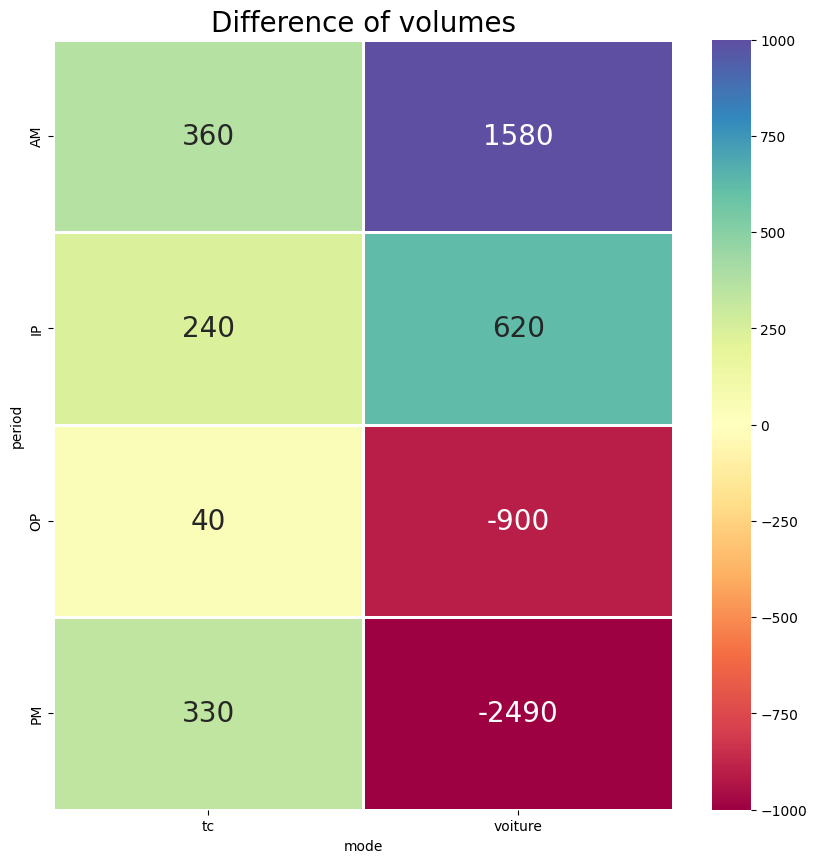

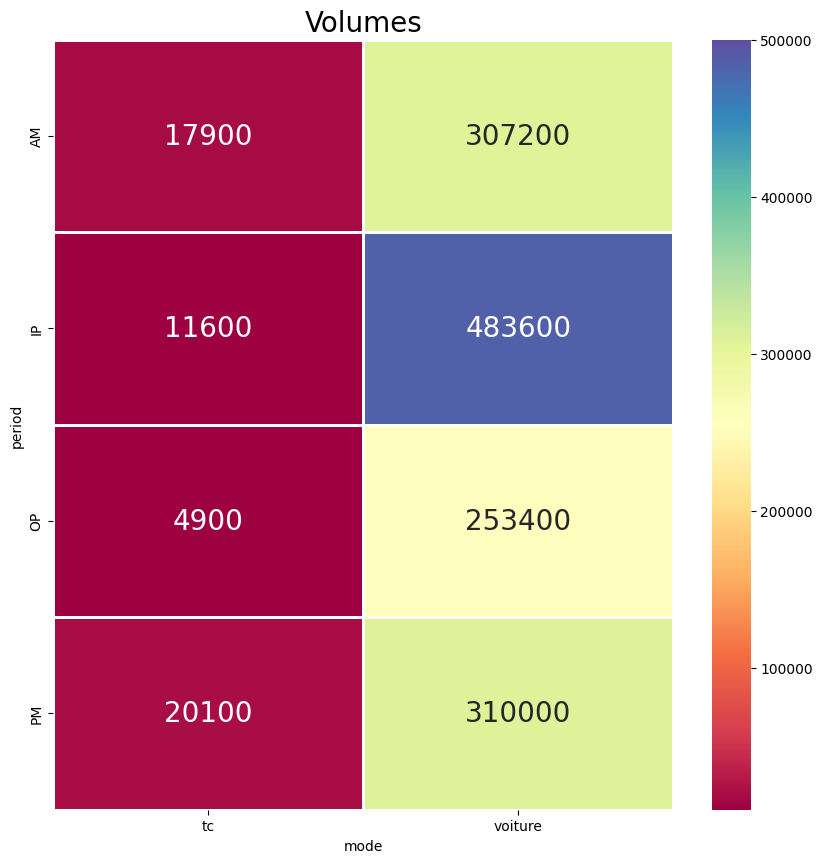

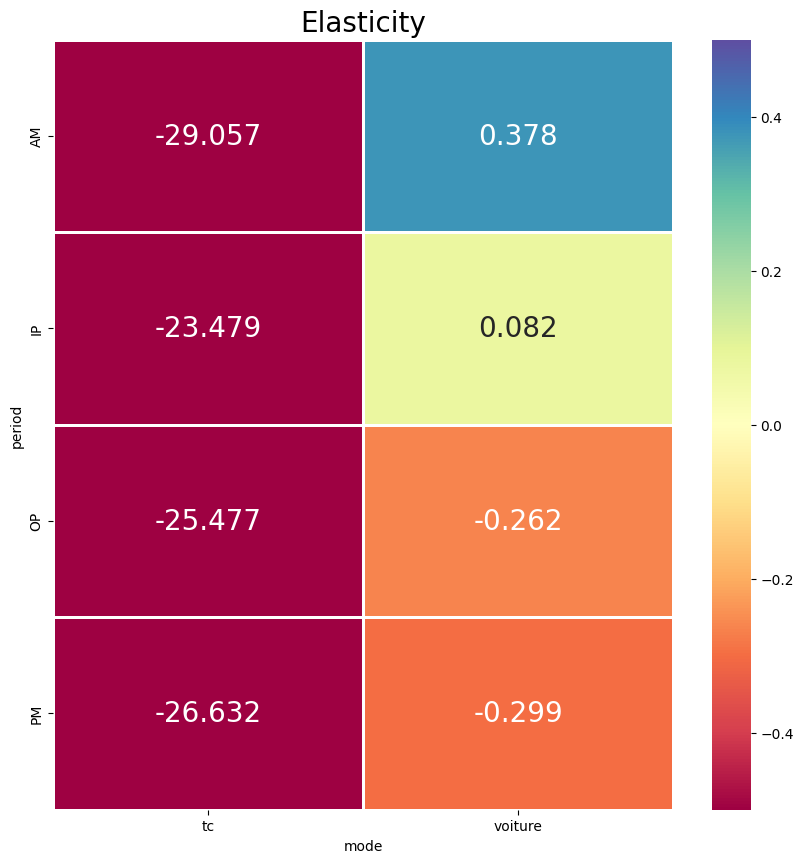

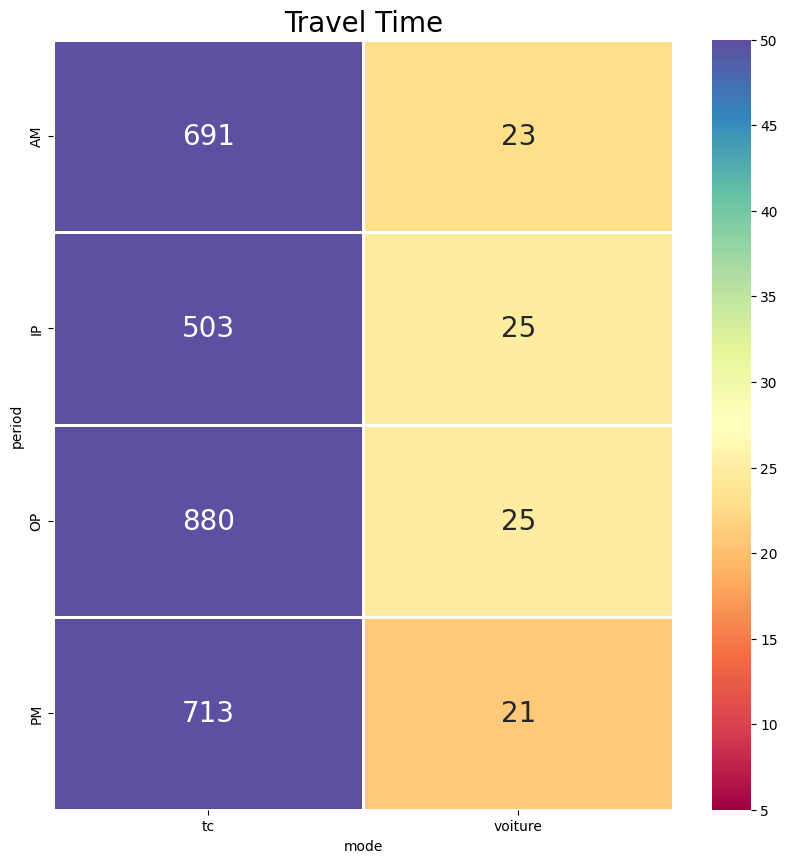

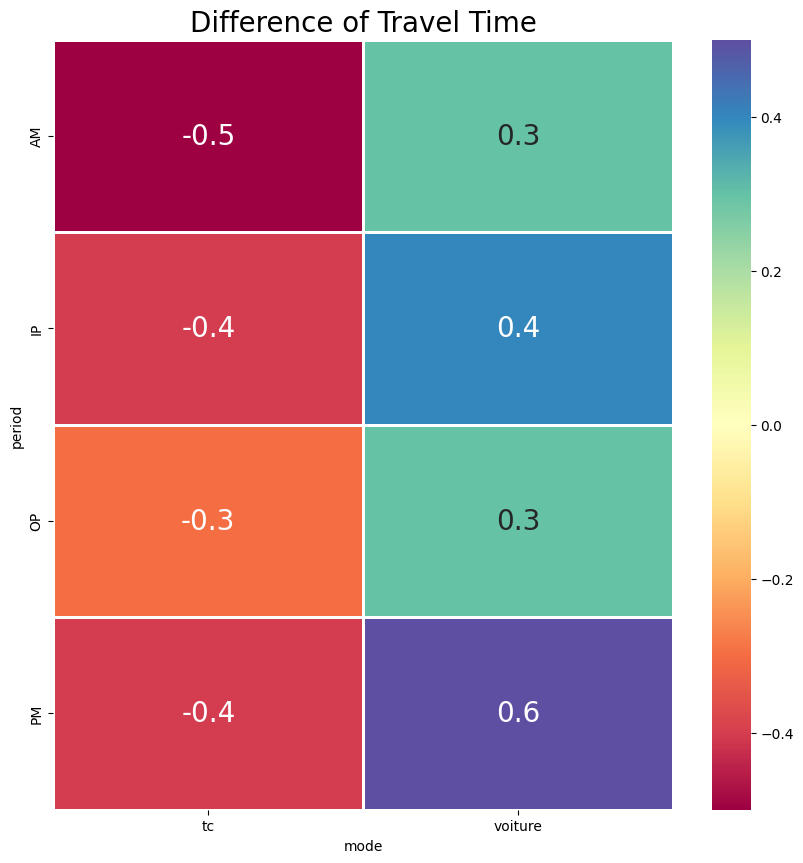

In [47]:
image_diff_vol = matrice_heat(matrice_diff_vol,-1000,1000,"Difference of volumes")
image_vol = matrice_heat(matrice_vol,10000,500000,"Volumes")
image_e = matrice_heat(matrice_el,-0.5,0.5,"Elasticity")
image_time = matrice_heat(matrice_time,5,50,"Travel Time")
image_diff_time = matrice_heat(matrice_diff_time,-0.5,0.5,"Difference of Travel Time")


In [48]:
image_matrix = [[image_diff_vol, image_vol],[image_time,image_diff_time],[image_e,image_e]]

In [49]:
image_file = output_folder + "tables.png"

In [50]:
combine_and_save(image_matrix,image_file )

/tmp/ipykernel_181685/1613346604.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb =  np.hstack( (np.asarray( i.resize(min_shape) ) for i in image_list) )
/tmp/ipykernel_181685/1613346604.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in image_list ) )


In [51]:
pd.concat([matrice_vol,matrice_diff_vol,matrice_time,matrice_diff_time,   matrice_el],axis =1,keys = ["vol","diff_vol","time","diff_time","elasticity"]).to_csv(output_folder +"tables.csv",sep =":")

## Sortie

## distribution des évolution OD

In [52]:
diff =diff_vol.copy()

In [53]:
evolution_OD = diff.groupby(level = ["origin","destination"]).sum()

In [54]:
evolution_OD_s_mode = diff.groupby(level = ["origin","destination","sub_mode"]).sum()

#### max bizarree 

In [55]:
evolution_OD.loc[evolution_OD == evolution_OD.max()]

origin    destination
zone_552  zone_574       236.562176
dtype: float64

In [56]:
evolution_OD_s_mode.loc[evolution_OD_s_mode == evolution_OD_s_mode.max()]

origin    destination  sub_mode
zone_552  zone_574     vp          236.562176
dtype: float64

In [57]:
diff.groupby(level = ["origin"]).sum().sort_values(ascending = False).head(5)

origin
zone_552    112.144365
zone_574     39.544704
zone_689     31.299279
zone_701     30.159436
zone_553     24.858651
dtype: float64

In [58]:
delta_utility_ijpcmts_factor.loc[:,"zone_574" ].groupby(level =["sub_mode"]).sum()

sub_mode
rail      0.000000
vp     -127.640136
dtype: float64

In [59]:
delta_utility_ijpcmts_factor.loc['zone_552'].groupby(level =["sub_mode"]).sum()

sub_mode
rail       0.000000
vp      1369.807091
dtype: float64

<Axes: >

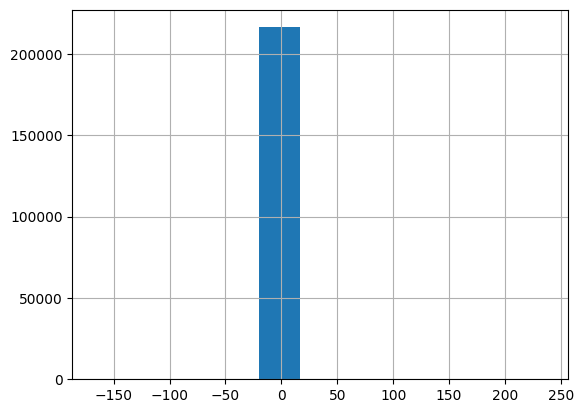

In [60]:
evolution_OD.hist(bins =11)# on peut voir sans les valeurs extrèmes aussi

<Axes: >

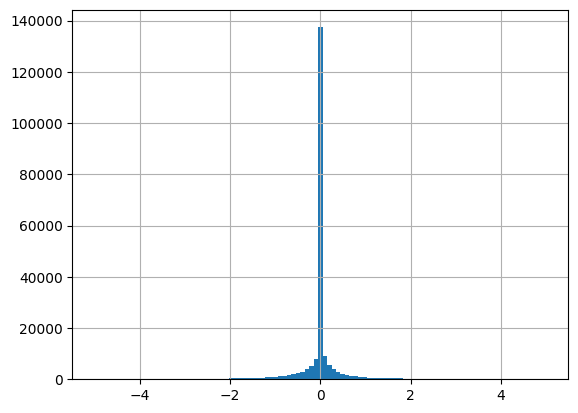

In [61]:
evolution_OD.loc[abs (evolution_OD)<5].hist(bins =101)#

In [62]:
diff_vp = evolution_OD_s_mode.loc[evolution_OD_s_mode.index.get_level_values("sub_mode") == "vp"]
diff_train = evolution_OD_s_mode.loc[evolution_OD_s_mode.index.get_level_values("sub_mode") == "rail"]
diff_autocar =  evolution_OD_s_mode.loc[evolution_OD_s_mode.index.get_level_values("sub_mode") == "autocar"]

<Axes: >

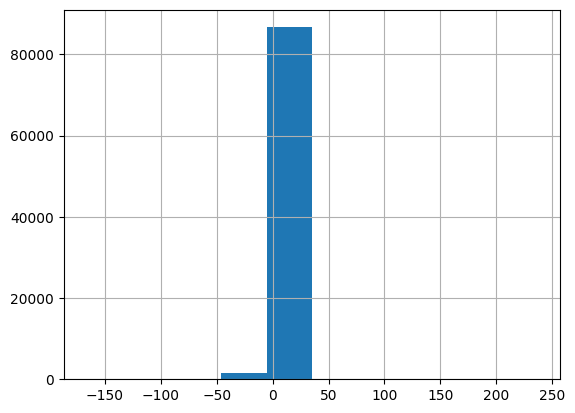

In [63]:
diff_vp.hist()

<Axes: >

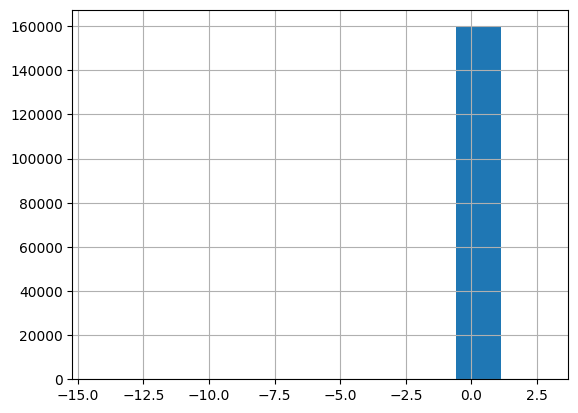

In [64]:
diff_train.hist()

<Axes: >

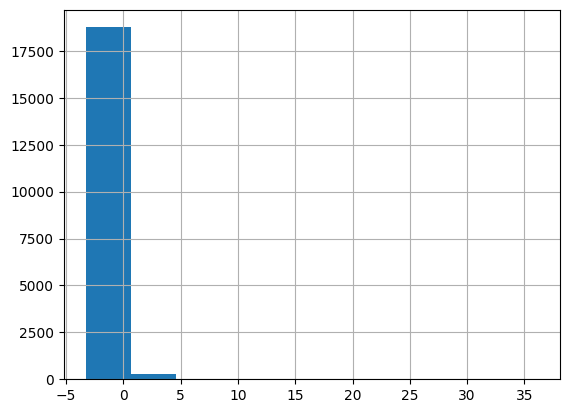

In [65]:
diff_autocar.hist()

In [66]:
diff.groupby(level = "sub_mode").sum(),diff.groupby(level = "mode").sum(),diff.groupby(level = "period").sum()

(sub_mode
 autocar    1242.413479
 rail       -271.287041
 vp        -1181.344165
 dtype: float64,
 mode
 tc          971.126438
 voiture   -1181.344165
 dtype: float64,
 period
 AM    1945.789876
 IP     856.729198
 OP    -859.674972
 PM   -2153.061830
 dtype: float64)

In [67]:
diff.groupby(level = ["period","sub_mode"]).sum()

period  sub_mode
AM      autocar      422.868824
        rail         -61.032176
        vp          1583.953228
IP      autocar      277.021977
        rail         -38.410728
        vp           618.117949
OP      autocar       78.384261
        rail         -41.926255
        vp          -896.132978
PM      autocar      464.138416
        rail        -129.917882
        vp         -2487.282364
dtype: float64

In [68]:
Londres = "zone_689"

In [69]:
skim.reset_index()

,index,origin,destination,time_period,vehicle_class,time,distance
0,0,zone_84,zone_12,PM,RPAX,4949.430488,NaN
1,1,zone_190,zone_475,IP,RPAX,18001.060855,NaN
2,2,zone_70,zone_111,OP,BPAX,1488.442267,NaN
3,3,zone_367,zone_541,PM,BPAX,7074.712400,NaN
4,4,zone_424,zone_429,OP,C_other,442.299545,6444.700195
...,...,...,...,...,...,...,...
597768,597768,zone_540,zone_530,IP,C_other,425.398804,6533.769531
597769,597769,zone_78,zone_457,AM,C_other,931.692749,14118.262695
597770,597770,zone_355,zone_331,IP,RPAX,31376.547370,NaN
597771,597771,zone_455,zone_15,PM,RPAX,12065.796341,NaN


In [70]:
time_ref_1 = ref_skim.reset_index().set_index(['index', 'origin', 'destination', 'time_period', 'vehicle_class','distance'])
time_proj_1 = skim.reset_index().set_index(['index', 'origin', 'destination', 'time_period', 'vehicle_class','distance'])
(time_ref_1.groupby(level = ["time_period","vehicle_class"]).sum()/60)/(time_ref_1.groupby(level = ["time_period","vehicle_class"]).count()) - (time_proj_1.groupby(level = ["time_period","vehicle_class"]).sum()/60)/(time_proj_1.groupby(level = ["time_period","vehicle_class"]).count())

time
time_period vehicle_class          
AM          BPAX           0.760249
            C_EB          -0.358324
            C_other       -0.523530
            RPAX           0.000000
IP          BPAX           0.616077
            C_EB          -0.086699
            C_other       -0.518523
            RPAX           0.000000
OP          BPAX           0.246334
            C_EB           0.088935
            C_other       -0.418849
            RPAX           0.000000
PM          BPAX           0.611657
            C_EB          -0.633811
            C_other       -0.854561
            RPAX           0.000000

In [71]:
time_ref_1.groupby(level = ["vehicle_class"]).mean()/1000

,time
vehicle_class,
BPAX,3.288475
C_EB,1.562481
C_other,1.915714
RPAX,39.811590


time_proj_1.loc[time_proj_1.index.get_level_values("origin") == Londres].groupby(level = ["time_period","vehicle_class"]).sum()/6000 - time_ref.loc[time_ref.index.get_level_values("origin") == Londres].groupby(level = ["time_period","vehicle_class"]).sum()/6000

time_ref.loc[time_ref.index.get_level_values("origin") == Londres].groupby(level = ["time_period","vehicle_class"]).sum()/6000

## Sortie graphiques

## Sorties cartes 

# OD

In [72]:
# faire un seule couche json pour centroids et pour zones, donc volumes pour centroids et time/part modale sur zones

In [73]:
centroids = gpd.read_file(input_folder+'base/zones/zones.geojson').to_crs(4326)
centroids ["index"] = "zone_" + centroids ["index"]
centroids  = centroids .set_index("index")


In [74]:
diff_vol.name = "volumes"
diff_vol_concat = diff_vol.reset_index().groupby(["origin","destination","sub_mode"])["volumes"].sum().unstack()
diff_vol_concat.columns = "diff_" + diff_vol_concat.columns
vol_concat = vol_ref.reset_index().groupby(["origin","destination","sub_mode"])["volumes"].sum().unstack()
vol_centroids = diff_vol_concat.merge(vol_concat, left_index = True, right_index = True).round(1)
OD_dict = {}
for c in vol_centroids.columns:
   s = vol_centroids[c]
   OD_dict[c] = {k: v[k].to_dict() for k, v in s.groupby(level=0)}
with open(os.path.join(output_folder, 'centroids.json'), 'w') as file:
    simplejson.dump(OD_dict, file, ignore_nan=True)
centroids.to_file(output_folder+'centroids.geojson',driver='GeoJSON')


In [75]:
zones = gpd.read_file(input_folder+'base/zones/voronoi.geojson').to_crs(4326)
zones["index"] = "zone_" + zones["index"]
zones  = zones.set_index("index")

In [76]:
#parametre de temps
avg_diff_time = vol_diff_time.groupby(level = ["origin","destination","sub_mode","period"]).sum()/vol_ref.groupby(level = ["origin","destination","sub_mode","period"]).sum()
avg_diff_time.name = "time"
# on ne fait les diff de time et time que pour vp et en am
diff_time_concat = avg_diff_time[(avg_diff_time.index.get_level_values("sub_mode") == "vp") & (avg_diff_time.index.get_level_values("period") == "AM")].reset_index().groupby(["origin","destination"])[["time"]].max().round(5)
diff_time_concat.columns = "diff_" + diff_time_concat.columns +"_AM"

time_concat = time_ref[(time_ref.index.get_level_values("sub_mode") == "vp") & (time_ref.index.get_level_values("period") == "AM")].reset_index().groupby(["origin","destination"])[["time_ref"]].max().round(5)
time_concat.columns =  time_concat.columns +"_AM"
time_zones = time_concat.merge(diff_time_concat, left_index = True, right_index = True)
#part modale
vol_proj.name = "volumes"
vol_proj_concat = vol_proj.reset_index().groupby(["origin","destination","sub_mode"])["volumes"].sum().unstack().round(5)
part_modale_ref = ((vol_concat/pd.DataFrame(vol_concat.sum(axis =1)).values)*100).fillna(0)
part_modale_proj= ((vol_proj_concat/pd.DataFrame(vol_proj_concat.sum(axis =1)).values)*100).fillna(0)
diff_part_modale = (part_modale_proj - part_modale_ref).fillna(0)
diff_part_modale_relative = ((diff_part_modale*100) /part_modale_ref).fillna(0)
diff_part_modale_relative.columns = "diff_part_modale_" + diff_part_modale_relative.columns +"_relative_%"
diff_part_modale.columns = "diff_part_modale_" + diff_part_modale.columns +"_%"
part_modale_ref.columns = "part_modal_ref_ " + part_modale_ref.columns 
part_modale_zones = part_modale_ref.merge(diff_part_modale, left_index = True, right_index = True)
part_modale_zones = part_modale_zones.merge(diff_part_modale_relative, left_index = True, right_index = True)
df_zones = part_modale_zones.merge(time_zones , left_index = True, right_index = True).round(1)
OD_dict = {}
for c in df_zones.columns:
   s = df_zones[c]
   OD_dict[c] = {k: v[k].to_dict() for k, v in s.groupby(level=0)}
with open(os.path.join(output_folder, 'zones.json'), 'w') as file:
    simplejson.dump(OD_dict, file, ignore_nan=True)
zones.to_file(output_folder+'zones.geojson',driver='GeoJSON')

# Origine

## centroids

In [77]:
diff_vol_period = diff_vol.reset_index().groupby(["origin","mode","period"])["volumes"].sum().unstack(1)
add_all = diff_vol.groupby(["origin","mode"]).sum().unstack()
add_all ["period"] = "All_Day"
add_all .set_index('period', append=True, inplace=True)
diff_vol_period = pd.concat([diff_vol_period,add_all])

In [78]:
vol_period = vol_ref.reset_index().groupby(["origin","mode","period"])["volumes"].sum().unstack(1)
add_all = vol_ref.groupby(["origin","mode"]).sum().unstack()
add_all ["period"] = "All_Day"
add_all .set_index('period', append=True, inplace=True)
vol_period = pd.concat([vol_period,add_all])
vol_period_relatif = (diff_vol_period/vol_period)*100
vol_period_relatif .columns = vol_period_relatif.columns + "_difference_volumes_%"

In [79]:
vol_centroids = vol_period.merge(diff_vol_period, left_index = True, right_index = True,suffixes = ("_volumes","_différence_volumes") )
vol_centroids = vol_centroids.merge(vol_period_relatif,left_index = True, right_index = True)
centroids.index.name = "origin"
gpd.GeoDataFrame(vol_centroids.round(1).join(centroids[["geometry"]])).to_file(output_folder+'centroids_volumes.geojson',driver='GeoJSON')


## zones

### part modale

In [80]:
vol_period_proj = vol_proj.reset_index().groupby(["origin","mode","period"])["volumes"].sum().unstack(1)
add_all = vol_proj.groupby(["origin","mode"]).sum().unstack()
add_all ["period"] = "All_Day"
add_all .set_index('period', append=True, inplace=True)
vol_period_proj = pd.concat([vol_period_proj ,add_all])

In [81]:

part_modale_ref = ((vol_period/pd.DataFrame(vol_period.sum(axis =1)).values) * 100).fillna(0)
part_modale_proj= ((vol_period_proj/pd.DataFrame(vol_period_proj.sum(axis =1)).values) * 100).fillna(0)
diff_part_modale = (part_modale_proj - part_modale_ref).fillna(0)
diff_part_modale_relative = ((diff_part_modale * 100) /part_modale_ref).fillna(0)
diff_part_modale_relative.columns = "diff_part_modale_" + diff_part_modale_relative.columns +"_relative_%"
diff_part_modale.columns = "diff_part_modale_" + diff_part_modale.columns +"_%"
part_modale_ref.columns = "part_modal_ref_ " + part_modale_ref.columns 
part_modale_zones = part_modale_ref.merge(diff_part_modale, left_index = True, right_index = True)
part_modale_zones = part_modale_zones.merge(diff_part_modale_relative, left_index = True, right_index = True)

In [82]:

zones.index.name = "origin"
gpd.GeoDataFrame(part_modale_zones.round(1).join(zones[["geometry"]])).to_file(output_folder+'zones_part_modale.geojson',driver='GeoJSON')

In [83]:
vol_time = vol_ref * time_ref

In [84]:
vol_diff_time.name = "time"
vol_time.name = "time"
diff_time_period = (vol_diff_time.reset_index().groupby(["origin","mode","period"])["time"].sum()/vol_ref.groupby(level = ["origin","mode","period"]).sum()).unstack(1)
time_period = (vol_time.reset_index().groupby(["origin","mode","period"])["time"].sum()/vol_ref.groupby(level = ["origin","mode","period"]).sum()).unstack(1)
time_zones  = time_period .merge(diff_time_period, left_index = True, right_index = True,suffixes = ("_time","_difference_time") )

In [85]:
gpd.GeoDataFrame(time_zones.round(1).join(zones[["geometry"]])).to_file(output_folder+'zones_time.geojson',driver='GeoJSON')

In [86]:
diff_time_period = (vol_diff_time.reset_index().groupby(["origin","sub_mode","period"])["time"].sum()/vol_ref.groupby(level = ["origin","sub_mode","period"]).sum()).unstack(1)
time_period = (vol_time.reset_index().groupby(["origin","sub_mode","period"])["time"].sum()/vol_ref.groupby(level = ["origin","sub_mode","period"]).sum()).unstack(1)
time_zones  = time_period .merge(diff_time_period, left_index = True, right_index = True,suffixes = ("_time","_difference_time") )
gpd.GeoDataFrame(time_zones.round(1).join(zones[["geometry"]])).to_file(output_folder+'zones_time_sub_mode.geojson',driver='GeoJSON')